## Import modules

In [33]:
import imblearn
import pandas as pd
import seaborn as sns
import dill
import matplotlib.pyplot as plt
import numpy as np
import time


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

## Data loading

In [40]:
random_state=809
# Load data from sources
data=pd.read_csv('./Lending Club/Lending_Club_Data.csv')
# Load jupyter session
dill.load_session('logistic_forest.db')
# Create test andd train
random_state = 809

## Data preprocessing

In [101]:
# Data cleaning and processing
data = data.fillna(0) # Fill na values with 0
for i in data.columns:  # Transform non-numeric types to string
    if data[i].dtypes == 'object':
        data[i] = data[i].astype('str')
# Enumerating categorical data
encoder = preprocessing.OrdinalEncoder()
encoder.fit(data)
data_encoded = encoder.transform(data)
# Dataframe creation
df = pd.DataFrame(data_encoded,columns=data.columns)
df = df.drop(["dti", "dti_joint", "emp_title", "dti_joint.1", "loan_id", "int_rate", "total_pymnt", "total_rec_int",
              "total_rec_late_fee", "total_rec_prncp", "recoveries"], axis=1)
variables = list(df.columns)
variables.remove('loan_status')
print(df.shape)


(922233, 41)


In [102]:
df.head(10)

,loan_status,loan_amnt,term,sub_grade,installment,issue_d,annual_inc,emp_length,verification_status,purpose,...,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,revol_bal_joint,annual_inc_joint,verification_status_joint
0,1.0,1320.0,1.0,15.0,53744.0,0.0,38792.0,3.0,2.0,2.0,...,1083.0,0.0,333044.0,352334.0,29.0,144867.0,1008.0,0.0,0.0,0.0
1,0.0,760.0,1.0,12.0,30020.0,0.0,16885.0,3.0,2.0,2.0,...,924.0,0.0,125061.0,262323.0,29.0,30574.0,875.0,0.0,0.0,0.0
2,0.0,560.0,1.0,19.0,24962.0,0.0,27275.0,1.0,0.0,2.0,...,1188.0,0.0,13020.0,3148.0,5.0,13061.0,744.0,0.0,0.0,0.0
3,0.0,408.0,0.0,10.0,23288.0,0.0,32096.0,2.0,1.0,2.0,...,713.0,0.0,89648.0,78688.0,23.0,91867.0,435.0,0.0,0.0,0.0
4,0.0,623.0,0.0,8.0,35716.0,0.0,13341.0,11.0,0.0,2.0,...,325.0,0.0,15830.0,68466.0,13.0,15871.0,4067.0,0.0,0.0,0.0
5,0.0,1160.0,1.0,18.0,50840.0,0.0,22400.0,7.0,2.0,8.0,...,455.0,0.0,9677.0,15605.0,7.0,9717.0,1424.0,0.0,0.0,0.0
6,0.0,560.0,0.0,17.0,35958.0,0.0,33120.0,0.0,0.0,10.0,...,536.0,0.0,90505.0,110099.0,21.0,92790.0,232.0,0.0,0.0,0.0
7,0.0,560.0,0.0,0.0,29280.0,0.0,29364.0,2.0,0.0,1.0,...,689.0,0.0,109098.0,113261.0,22.0,112214.0,1721.0,0.0,0.0,0.0
8,0.0,361.0,0.0,33.0,26810.0,0.0,25396.0,11.0,0.0,10.0,...,838.0,0.0,40488.0,33881.0,7.0,40537.0,477.0,0.0,0.0,0.0
9,0.0,80.0,0.0,16.0,4003.0,0.0,3618.0,4.0,2.0,9.0,...,841.0,0.0,7003.0,1999.0,11.0,7043.0,134.0,0.0,0.0,0.0


In this setup, 0 incates defaulter and 1 non-defaulter. Let's change this.


## Change abnormal values

In [103]:
df["loan_status"].replace((0, 1), (1, 0), inplace=True)
df.head(10)

,loan_status,loan_amnt,term,sub_grade,installment,issue_d,annual_inc,emp_length,verification_status,purpose,...,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,revol_bal_joint,annual_inc_joint,verification_status_joint
0,0.0,1320.0,1.0,15.0,53744.0,0.0,38792.0,3.0,2.0,2.0,...,1083.0,0.0,333044.0,352334.0,29.0,144867.0,1008.0,0.0,0.0,0.0
1,1.0,760.0,1.0,12.0,30020.0,0.0,16885.0,3.0,2.0,2.0,...,924.0,0.0,125061.0,262323.0,29.0,30574.0,875.0,0.0,0.0,0.0
2,1.0,560.0,1.0,19.0,24962.0,0.0,27275.0,1.0,0.0,2.0,...,1188.0,0.0,13020.0,3148.0,5.0,13061.0,744.0,0.0,0.0,0.0
3,1.0,408.0,0.0,10.0,23288.0,0.0,32096.0,2.0,1.0,2.0,...,713.0,0.0,89648.0,78688.0,23.0,91867.0,435.0,0.0,0.0,0.0
4,1.0,623.0,0.0,8.0,35716.0,0.0,13341.0,11.0,0.0,2.0,...,325.0,0.0,15830.0,68466.0,13.0,15871.0,4067.0,0.0,0.0,0.0
5,1.0,1160.0,1.0,18.0,50840.0,0.0,22400.0,7.0,2.0,8.0,...,455.0,0.0,9677.0,15605.0,7.0,9717.0,1424.0,0.0,0.0,0.0
6,1.0,560.0,0.0,17.0,35958.0,0.0,33120.0,0.0,0.0,10.0,...,536.0,0.0,90505.0,110099.0,21.0,92790.0,232.0,0.0,0.0,0.0
7,1.0,560.0,0.0,0.0,29280.0,0.0,29364.0,2.0,0.0,1.0,...,689.0,0.0,109098.0,113261.0,22.0,112214.0,1721.0,0.0,0.0,0.0
8,1.0,361.0,0.0,33.0,26810.0,0.0,25396.0,11.0,0.0,10.0,...,838.0,0.0,40488.0,33881.0,7.0,40537.0,477.0,0.0,0.0,0.0
9,1.0,80.0,0.0,16.0,4003.0,0.0,3618.0,4.0,2.0,9.0,...,841.0,0.0,7003.0,1999.0,11.0,7043.0,134.0,0.0,0.0,0.0


## Select subset from orginal dataset

Data set too big for effciently fitting the models.

In [105]:
# Randomly sample 50% of your dataframe
df = df.sample(frac=0.5)
df.head(10)
print(df.shape)

(461116, 41)


## Split data

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['loan_status'], axis=1),
                                                    df['loan_status'], test_size=0.3,
                                                    random_state=random_state)

In [52]:
df = pd.DataFrame(X_train, columns = variables)
df['loan_status'] = y_train

## Check data balancing

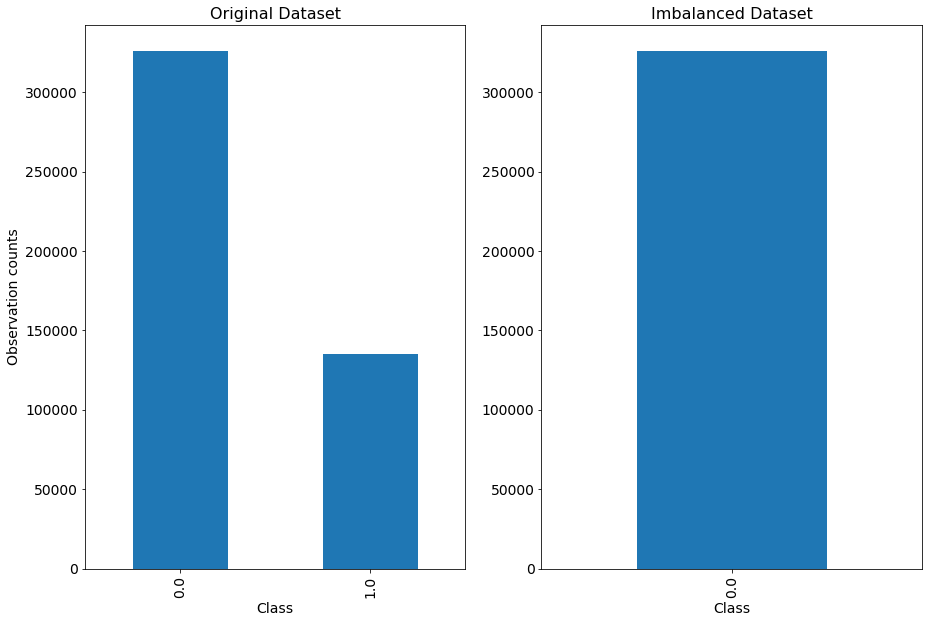

In [107]:
df_0 = df[df['loan_status']==0]
df_1 = df[df['loan_status']==1]

# Plot of the outcome variable in both datasets
fig, (ax, ax1) = plt.subplots(figsize=(15,10), ncols = 2)
df['loan_status'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
df_0['loan_status'].value_counts().plot(kind='bar', ax=ax1, fontsize=14)
ax.set_ylabel('Observation counts', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
ax1.set_xlabel('Class', fontsize=14)
ax.set_title('Original Dataset', fontsize=16)
ax1.set_title('Imbalanced Dataset', fontsize=16)
plt.show()

Clearly we appreciate a significant imbalance of class 1 with respect to class 0.

Thus, we need to balance the data. In class we learned about several methods to balance imbalanced datasets.
In this case, we will use smote procedure.

## Logit model with imbalanced data

In [135]:
# Parameter optimisation
C = [1, 1/2, 1/3, 1/4, 1/5, 1/10]
param_grid = {'C': C}
logit_imb = LogisticRegression(penalty="l1",
                         solver="liblinear",
                         max_iter=int(1e6),
                         warm_start=True)
cv = 3  # Cross-validation folds
cv_logit_imb = GridSearchCV(estimator=logit_imb, param_grid=param_grid, verbose=10, cv=cv, n_jobs=-1)
cv_logit_imb.fit(df[variables], df['loan_status'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000000, penalty='l1',
                                          solver='liblinear', warm_start=True),
             n_jobs=-1,
             param_grid={'C': [1, 0.5, 0.3333333333333333, 0.25, 0.2, 0.1]},
             verbose=10)

In [138]:
optimal_logit_imb = cv_logit_imb.best_estimator_
best_parameters_logit_imb = cv_logit_imb.best_params_
print('The best Parameters are:')
for key, item in best_parameters_logit_imb.items():
    print(f'- {key}: {item}')

The best Parameters are:
- C: 1


In [139]:
print(f'Logistic score imbalanced: {optimal_logit_imb.score(X_test, y_test)}')

Logistic score imbalanced: 0.7229334586330285


## Confusion matrix

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


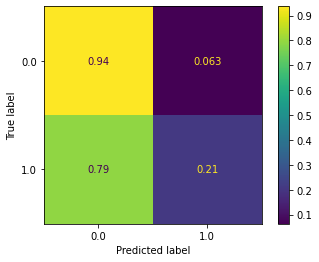

In [140]:
plot_confusion_matrix(optimal_logit_imb, X_test, y_test, normalize='true')

### Plot ROC curves

In [141]:
def plot_roc_precision(model, X_test, y_test):
    fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,10))
    plot_roc_curve(model, X_test, y_test, ax=ax)
    plot_precision_recall_curve(model, X_test, y_test, ax=ax1)
    ax.set_title('ROC', fontsize=18)
    ax1.set_title('Precision Recall', fontsize=18)
    ax.legend(fontsize=15)
    ax1.legend(fontsize=15)
    plt.suptitle('Balanced Dataset', fontsize=20)
    plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


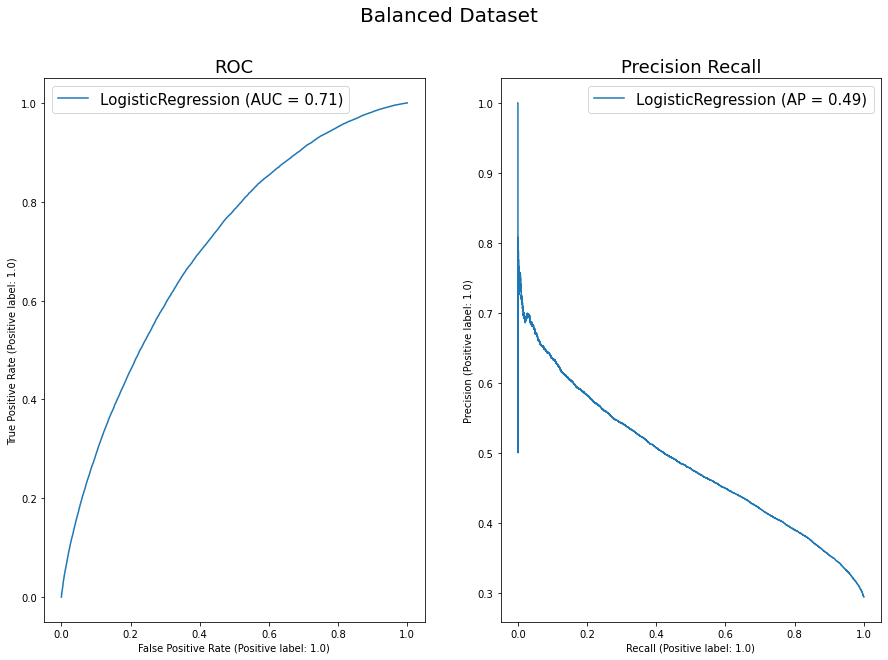

In [142]:
plot_roc_precision(optimal_logit_imb,  X_test, y_test)

The area under the curve is far from being maximized. This indicates a great rate of FN.

### Data balancing with oversampling

In [143]:
oversampler = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
oversample_x, oversample_y = oversampler.fit_resample(df[variables], df['loan_status'])
df_oversampled = pd.DataFrame(oversample_x, columns = variables)
df_oversampled['loan_status'] = oversample_y

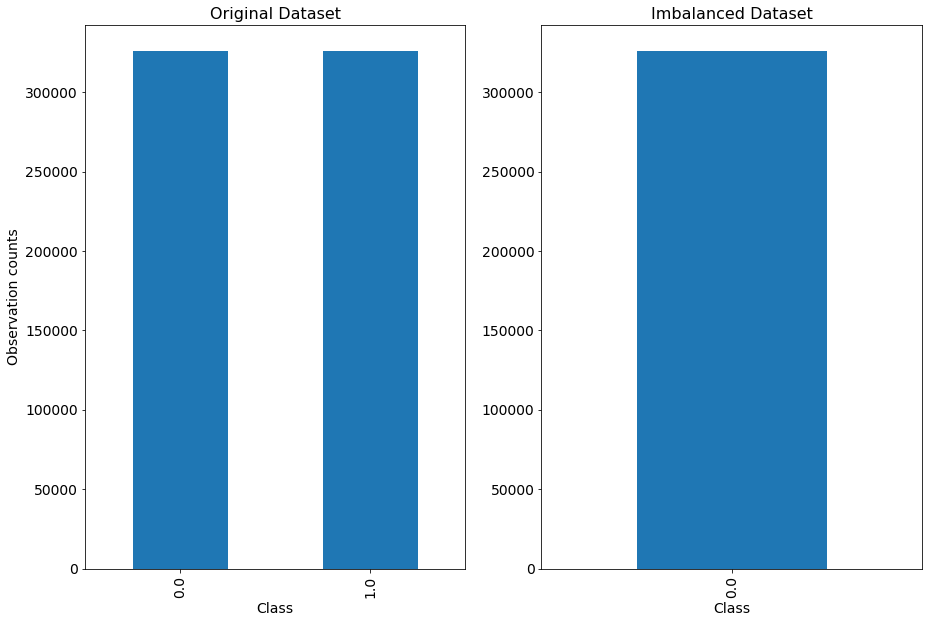

In [144]:
df_0_under = df_oversampled[df_oversampled['loan_status']==0]
df_1_under = df_oversampled[df_oversampled['loan_status']==1]

# Plot of the outcome variable in both datasets
fig, (ax, ax1) = plt.subplots(figsize=(15,10), ncols = 2)
df_oversampled['loan_status'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
df_0_under['loan_status'].value_counts().plot(kind='bar', ax=ax1, fontsize=14)
ax.set_ylabel('Observation counts', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
ax1.set_xlabel('Class', fontsize=14)
ax.set_title('Original Dataset', fontsize=16)
ax1.set_title('Imbalanced Dataset', fontsize=16)
plt.show()

## Balanced logit

In [146]:
# Parameter optimisation
C = [10, 5, 1, 1/2, 1/4, 1/10]
param_grid = {'C': C}
logit_balanced = LogisticRegression(penalty="l1",
                         solver="liblinear",
                         max_iter=int(1e6),
                         warm_start=True)
cv = 3  # Cross-validation folds
cv_logit_balanced = GridSearchCV(estimator=logit_balanced, param_grid=param_grid, verbose=10, cv=cv, n_jobs=-1)
cv_logit_balanced.fit(df_oversampled[variables], df_oversampled['loan_status'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 3/6] START C=1.........................................................
[CV 1/3; 3/6] END ..........................C=1;, score=0.650 total time= 6.5min
[CV 2/3; 3/6] START C=1.........................................................
[CV 2/3; 3/6] END ..........................C=1;, score=0.649 total time= 6.5min


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000000, penalty='l1',
                                          solver='liblinear', warm_start=True),
             n_jobs=-1, param_grid={'C': [10, 5, 1, 0.5, 0.25, 0.1]},
             verbose=10)

In [147]:
optimal_logit_balanced = cv_logit_balanced.best_estimator_
best_parameters_logit_balanced = cv_logit_balanced.best_params_
print('The best Parameters are:')
for key, item in best_parameters_logit_imb.items():
    print(f'- {key}: {item}')

The best Parameters are:
- C: 1


In [148]:
print(f'Logistic score oversampled: {optimal_logit_balanced.score(X_test, y_test)}')

Logistic score oversampled: 0.6521993710919145


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


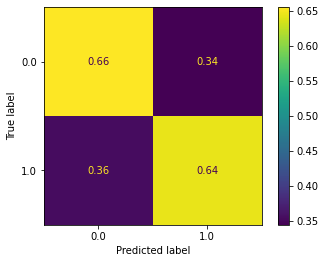

In [149]:
plot_confusion_matrix(optimal_logit_balanced, X_test, y_test, normalize='true')

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


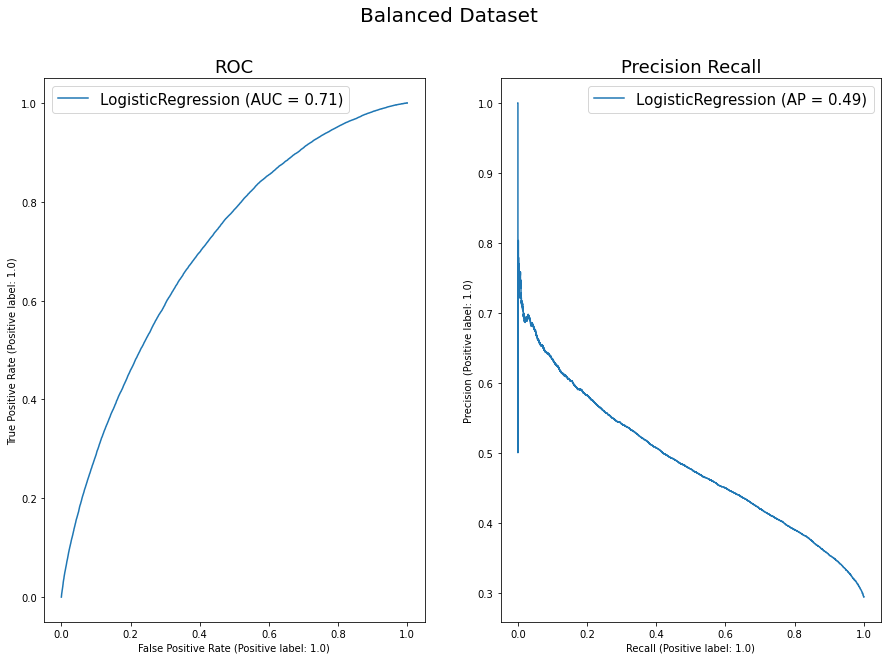

In [151]:
plot_roc_precision(optimal_logit_balanced,  X_test, y_test)

Note that the ROC and precission recall curves indicate that oversampoling the dataset does not improve the performance of the model. 

In [159]:
# We Create a Pipeline to do three things to the training FOLDS:
#1- Apply Smote to it
#2- Apply a MinMax Scaler to the data
#3- Apply the KNN9rrrrrrrrrrrrrrrrrr

pipeline = imbpipeline(steps = [('smote', SMOTE(random_state=random_state)), ('scaler', MinMaxScaler()),
                                ('classifier', LogisticRegression(penalty="l1",solver="liblinear",max_iter=int(1e6),warm_start=True))])
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
param_grid = {'smote__k_neighbors': [1, 2, 3, 5, 10],'classifier__C': C}
grid_search = GridSearchCV(estimator=pipeline,
                            param_grid=param_grid,
                            scoring='average_precision',
                            cv=cv,
                            verbose=10,
                            n_jobs=-1)


In [ ]:
grid_search.fit(df[variables], df['loan_status'])
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [53]:
# Retreive best model 
optimal_logit_smote = grid_search.best_estimator_["classifier"]
print(grid_search.best_estimator_["smote"])
print(model_imb.score(X_test, y_test))

SMOTE(k_neighbors=1, random_state=809)
0.6532258647486174
0.7243719955181263


In [9]:
grid_search.best_estimator_["classifier"].coef_[0]

array([-2.96657097e-01, -5.86283800e-01, -2.80318795e+00, -5.96372051e-01,
        2.09761240e-02,  4.28770477e-01,  8.11435062e-02, -5.56734067e-02,
       -9.66676312e-02, -3.13927130e-01,  5.38974095e-02,  7.69917397e-02,
        4.13221431e-01, -8.71408228e-01, -5.52185128e-01, -1.72769318e-02,
       -6.60234757e-01,  1.86404027e+00, -1.07455530e+00,  1.06912298e-01,
       -2.62326423e+00, -5.76274957e-01, -1.44607109e+00, -2.87884080e+00,
       -1.16074675e+00,  9.49736408e-02, -4.67916074e-02, -7.05135119e-01,
       -3.59766009e-01,  3.48769575e-01,  8.27025941e-02,  0.00000000e+00,
       -4.51029412e-01,  4.52459381e-01,  2.63046396e+00, -9.95951162e-02,
        9.62728684e-01, -5.92317509e-01,  7.25475238e-01,  1.18562413e-03])

Let's see the effect of smote in the training set:

### Logistic coefficients

In [11]:
list_tuples = list(zip(variables, np.round(optimal_logit_smote.coef_[0], 2)))
coef_df = pd.DataFrame(list_tuples, columns =['Predictor', 'Logistic COEF'])
coef_df

,Predictor,Logistic COEF
0,loan_amnt,-0.30
1,term,-0.59
2,sub_grade,-2.80
3,installment,-0.60
4,issue_d,0.02
5,annual_inc,0.43
6,emp_length,0.08
7,verification_status,-0.06
8,purpose,-0.10
9,home_ownership,-0.31


### Omitted predictors by Logistic model

Note that we are using l1 norm as penalty in the logistic model. Therefore, the shrinkage is performed, allogwing variable selection.

In [4]:
# Omitted
coef_df[coef_df['Logistic COEF'] == 0]

,Predictor,Logistic COEF
31,tax_liens,0.0
39,verification_status_joint,0.0


### Selected predictors by Logistic model

In [13]:
# Selected
coef_df[coef_df['Logistic COEF'] != 0]

,Predictor,Logistic COEF
0,loan_amnt,-0.30
1,term,-0.59
2,sub_grade,-2.80
3,installment,-0.60
4,issue_d,0.02
5,annual_inc,0.43
6,emp_length,0.08
7,verification_status,-0.06
8,purpose,-0.10
9,home_ownership,-0.31


### Retrieve oversampled dataset 

In [32]:
scaler = grid_search.best_estimator_["scaler"]
X_test_scaled = X_test
X_test_scaled[X_test_scaled.columns] = scaler.fit_transform(X_test[X_test.columns])

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


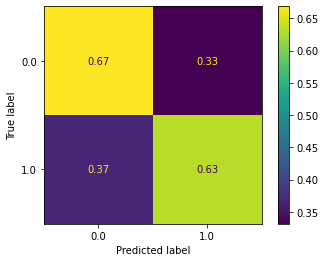

In [30]:
plot_confusion_matrix(optimal_logit_smote, X_test_scaled, y_test, normalize='true')

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.p

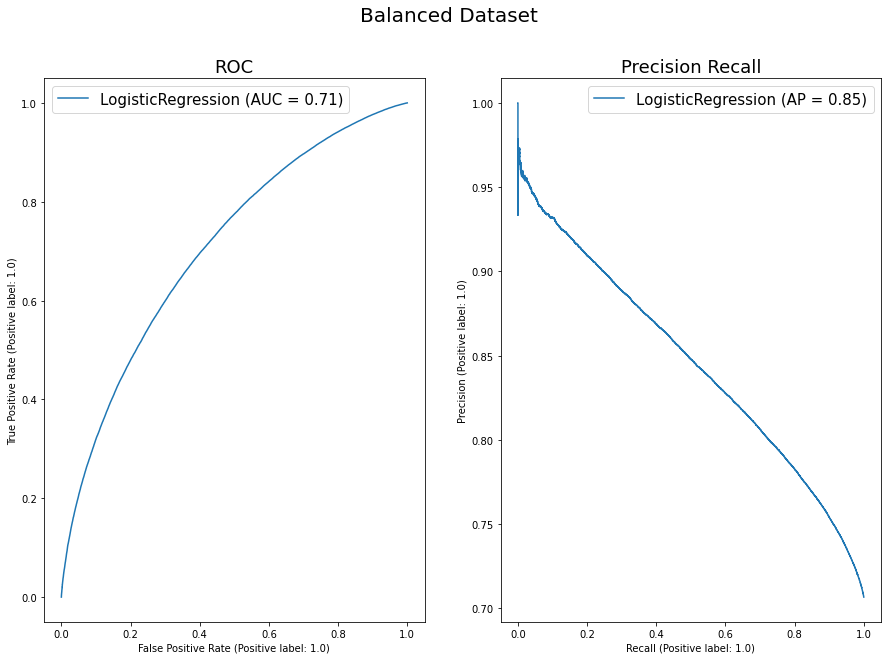

In [29]:
plot_roc_precision(optimal_logit_smote,  X_test_scaled, y_test)

### Random forest

Let's scale the oversampled data and delete penalized variables by logistic


In [18]:
df_smote_scaled = df_smote
df_smote_scaled[df_smote_scaled.columns] = scaler.fit_transform(df_smote_scaled[df_smote_scaled.columns])

Delete penalized variables by logistic

In [8]:
X_train_scaled = smote_x
X_train_scaled[X_train_scaled.columns] = scaler.fit_transform(X_train_scaled[X_train_scaled.columns])
X_train_scaled = X_train_scaled.drop(["tax_liens", "verification_status_joint"], axis=1)
X_test_scaled = X_test_scaled.drop(["tax_liens", "verification_status_joint"], axis=1)

#### Find optimal hyperparameters

In [155]:
# Parameter optimisation
n_estimators = [200, 500, 1000]
max_features = ['sqrt', 0.5]
max_depth = [20, 50, 100]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
rfc = RandomForestClassifier(random_state=random_state, n_jobs=-1)
n_iter = 10  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
cv = 3  # Cross-validation folds
rf_random = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=n_iter, cv=cv,
                               random_state=random_state, n_jobs=-1, scoring='average_precision')

rf_random.fit(X_train_scaled, smote_y)
best_parameters = rf_random.best_params_
print('The best Parameters are:')
for key, item in best_parameters.items():
    print(f'- {key}: {item}')

In [28]:
X_train_scaled.columns

Index(['loan_amnt', 'term', 'sub_grade', 'installment', 'issue_d',
       'annual_inc', 'emp_length', 'verification_status', 'purpose',
       'home_ownership', 'addr_state', 'zip_code', 'avg_cur_bal',
       'delinq_2yrs', 'delinq_amnt', 'earliest_cr_line', 'inq_last_6mths',
       'open_acc', 'open_il_12m', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
       'num_tl_90g_dpd_24m', 'percent_bc_gt_75', 'pub_rec',
       'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit',
       'revol_bal_joint', 'annual_inc_joint'],
      dtype='object')

#### Run optimized random forest

In [140]:
rfc_opt = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features = 'sqrt',
                                 max_depth=100, random_state=random_state, n_jobs=-1)
rfc_opt.fit(X_train_scaled, smote_y)
rfc_opt.score(X_test_scaled, y_test)

0.9975421982867676

In [31]:
rfc_opt = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features = 'sqrt',
                                 max_depth=100, random_state=random_state, n_jobs=-1)
rfc_opt.fit(X_train_scaled, smote_y)
rfc_opt.score(X_test_scaled, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- tax_liens
- verification_status_joint
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 40 features, but RandomForestClassifier is expecting 38 features as input.